# [5SSD0] Probabilistic Programming - Assignment

Author: Wouter M. Kouw

---

In this assignment, you will apply polynomial regression to predict how much sound an airfoil makes during flight.

In [431]:
using Pkg
Pkg.activate("workspace")
Pkg.instantiate();

  Activating environment at `C:\Users\lange\OneDrive - TU Eindhoven\master\2021-2022\Q2\5SSD0 - Bayesian Machine Learning and Information Processing\prob-programming\pp-assignment\workspace\Project.toml`


In [432]:
using CSV
using Random
using LinearAlgebra
using DataFrames
using ProgressMeter
using ForneyLab
using Plots
pyplot();

### Problem: Airfoil self-noise

Among other matters, NASA studies how various design factors affect the noise an airfoil makes. In short, the way the wind travels past the foil creates vortices of different shapes. A vortex pushes and pulls the wing which causes it to oscillate and generate sound waves. The figure below shows two designs: a sharp trailing edge (left) and a blunt edge (right). 

<div> 
    <table>
        <tr>
            <td> <img src="figures/Airfoil-schematic-02.png"> </td>
            <td> <img src="figures/Airfoil-schematic-04.png"/> </td>
        </tr>
    </table>
</div>

NASA performed experiments with these airfoils in a windtunnel. They varied several design features, measured oscillation frequency and recorded sound amplitude levels. The results were published as a technical report and the data has been made publicly available ([data set](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise)). I have split it into training and test sets for this assignment.

Reference: [Brooks, Pope & Marcolini (1989). Airfoil self-noise and prediction, NASA RP 1218](https://ntrs.nasa.gov/api/citations/19890016302/downloads/19890016302.pdf)

For now, we will only consider regressing the feature "Frequency" onto the feature "Sound amplitude".

In [433]:
# Load training data
trn_data = DataFrame(CSV.File("data/airfoil_trn.csv"))
trn_input = log10.(trn_data[:,1])
trn_output = trn_data[:,6];
N = size(trn_data,1)

# Load test data
tst_data = DataFrame(CSV.File("data/airfoil_tst.csv"));
tst_input = log10.(tst_data[:,1])
tst_output = tst_data[:,6];
M = size(tst_data,1);

Let's visualize this relationship.

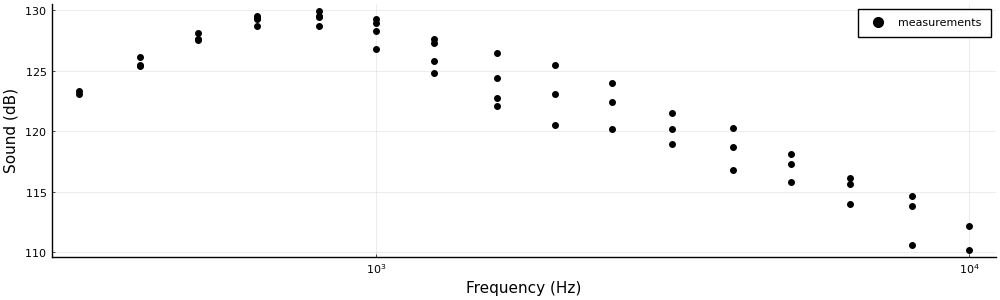

In [434]:
scatter(trn_data[:,1], trn_output, size=(1000,300), color="black", xscale=:log10, xlabel="Frequency (Hz)", ylabel="Sound (dB)", label="measurements")

At first glance, there seems to be a nonlinear relation between these two variables. But it's still relatively smooth, so we don't need a highly flexible function approximator. A polynomial should fit nicely.

### Polynomial regression

We can fit a curve by applying a polynomial basis expansion to the data points. To fit a polynomial of order $d$, we define a basis expansion function $\phi : \mathbb{R} \rightarrow \mathbb{R}^{d+1}$, where 

$$\phi(x) = \begin{bmatrix} 1 & x & x^2 & x^3 & \dots & x^d \end{bmatrix} \, .$$

Our regression model will be:

$$ y_k = \sum_{i=1}^{d+1} \theta_i \phi_i(x_k) + e_k \, ,$$ 

where $\phi_i(x)$ indicates the $i$-th element of the expanded vector. The noise follows a zero-mean Gaussian distribution with precision parameter $\tau$: 

$$e_k \sim \mathcal{N}(0, \tau^{-1}) \, .$$ 

Note that although this model is polynomial in the data, it remains linear in the coefficients. Our goal will be to estimate appropriate coefficients and make accurate predictions for future data points.

A useful step is to precompute the polynomial expansion for all data points:

$$ V = \begin{bmatrix} 1 & x_1 & x_1^2 & \dots x_1^d \\
                       1 & x_2 & x_2^2 & \dots x_2^d \\
                       \vdots & \vdots & \ddots & \vdots \\ 
                       1 & x_N & x_N^2 & \dots x_N^d \end{bmatrix} \quad .$$
                       
This is called a [Vandermonde](https://en.wikipedia.org/wiki/Vandermonde_matrix) matrix. Below is an example of how to make one:

In [435]:
# Order of polynomial
d = 3

# Polynomial basis function
ϕ(x) = [x.^j for j in 0:d]

# Vandermonde matrix
# V = hcat(ϕ(trn_input)...)

ϕ (generic function with 1 method)

## [2pt] Question 1 

- Specify a polynomial regression model of order $d = 3$ using ForneyLab.jl. 
- Define a message passing algorithm.
- Infer a posterior distribution for the coefficients. 

For now, you may fix the precision of the likelihood function as follows: 
- Calculate the variance of the observed signal per distinct frequency level, invert these values and average over them.

In [462]:
# Fixed precision
### YOUR CODE HERE ###

variance = Array{Float64}(undef, length(freq_groups)) 
freq_groups = groupby(trn_data, [1]) # group data by frequency

# println(freq_groups)

# calculate variance
for (i, group) in enumerate(freq_groups)
#     variance[i] = var(log10.(freq_groups[i][:,6])) 
    variance[i] = var(freq_groups[i][:,6]) 
    println(freq_groups[i][:,6])
end

precision = mean(inv.(variance)) # precision = τ
# println(precision)
variance = inv(precision)
# println(variance)


[129.354, 129.569, 129.292, 128.698]
[129.494, 129.949, 129.552, 128.708]
[129.004, 129.329, 128.312, 126.838]
[127.634, 127.329, 125.802, 124.838]
[126.514, 124.439, 122.782, 122.088]
[125.524, 123.069, 120.532]
[124.024, 122.439, 120.162]
[121.514, 120.189, 118.922]
[120.264, 118.689, 116.792]
[118.134, 117.309, 115.792]
[116.134, 115.679, 114.042]
[114.634, 113.799, 110.652]
[110.224, 112.169]
[126.159, 125.472, 125.398]
[128.179, 127.632, 127.548]
[123.312, 123.118]


0.1915481809846743

In [437]:
# Specify model, define message passing algorithm and infer posteriors
### YOUR CODE HERE ###
σ2_Y = variance
V_trn = hcat(ϕ(trn_input)...)

# Start factor graph
graph = FactorGraph();

# Prior weight parameters
μ_θ = zeros(d+1)
Σ_θ = Diagonal(ones(d+1))

# Add weight prior to graph
@RV θ ~ GaussianMeanVariance(μ_θ, Σ_θ, id=:f_a)

# Pre-define vectors for storing latent and observed variables
X = Vector{Variable}(undef, N) 
Y = Vector{Variable}(undef, N)

# build our factor graph
for i = 1:N
    # Define i-th covariate
    @RV X[i]
    
    # Define likelihood of i-th response
    @RV Y[i] ~ GaussianMeanVariance(dot(θ,X[i]), σ2_Y, id=Symbol("f_b"*string(i)))

    # Designate observed variables
    placeholder(X[i], :X, index=i, dims=(4,))
    placeholder(Y[i], :Y, index=i);
    
end

# Load data
data = Dict(:X => [V_trn[i, :] for i = 1:N],
            :Y => trn_output)

# # GET POSTERIOR
posterior = Dict()

# # Define and compile the algorithm
algorithm = messagePassingAlgorithm(θ) 
source_code = algorithmSourceCode(algorithm)

# # Evaluate the generated code to get the step! function
eval(Meta.parse(source_code));

# # Update posterior for θ
step!(data, posterior);


The following cells visualize the regression function using a MAP estimate based on your computed posterior distribution.

In [438]:
# Extract maximum a posteriori (MAP) estimate from posterior
θ_MAP = ForneyLab.unsafeMode(posterior[:θ])

4-element Vector{Float64}:
 28.581156682574147
 34.125068818742875
  9.569436546575162
 -3.31436379992374

(The `unsafe` function used above is a ForneyLab internal method to deal with potential numerical instabilities.)

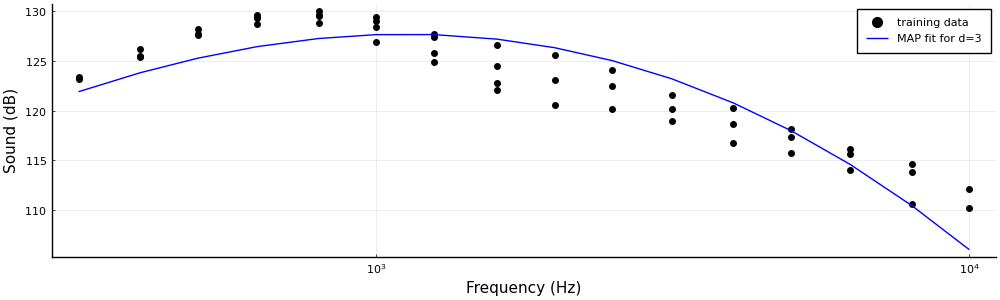

In [439]:
# Generate Vandermonde matrix for training data
V_trn = hcat(ϕ(trn_input)...);

# Sorted index for training inputs (necessary for plotting a line)
sortedix_trn = sortperm(trn_input)

# Visualize fit of current MAP estimate in model
scatter(trn_data[:,1], trn_output, size=(1000,300), color="black", xscale=:log10, xlabel="Frequency (Hz)", ylabel="Sound (dB)", label="training data")
plot!(trn_data[sortedix_trn,1], V_trn[sortedix_trn,:]*θ_MAP, color="blue", label="MAP fit for d=3")

## [1pt] Question 2

- Compute the posterior predictive distribution for each test data point.
- Scatter the test data points (frequency in `xscale=:log10` on x-axis, sound on y-axis).
- Add the means of the posterior predictive distributions as a solid line.
- Add the prediction uncertainty margin of +/- $\sigma$ around the means (use the `ribbon=` keyword argument for this purpose).

[0.4444849187236503, 0.44462367807967185, 0.4446890486055794, 0.44481620582135817, 0.44540321947172656, 0.44699658469497927, 0.45066115099593806, 0.4757509941344661, 0.4659045210584625, 0.4579650546570583, 0.4520023567560589, 0.44824423051263323, 0.44587073503054403, 0.44464789142537764, 0.44426636334208935, 0.4442929325328446, 0.4444849187236503, 0.44462367807967185, 0.4446890486055794, 0.44481620582135817, 0.44540321947172656, 0.44699658469497927, 0.45066115099593806, 0.4757509941344661, 0.4659045210584625, 0.4579650546570583, 0.4520023567560589, 0.44824423051263323, 0.44587073503054403, 0.44464789142537764, 0.44426636334208935, 0.4442929325328446, 0.4444849187236503, 0.44462367807967185, 0.4446890486055794, 0.44481620582135817, 0.44540321947172656, 0.44699658469497927, 0.45066115099593806, 0.4757509941344661, 0.4659045210584625, 0.4579650546570583, 0.4520023567560589, 0.44824423051263323, 0.44587073503054403, 0.44464789142537764, 0.44426636334208935, 0.4442929325328446, 0.4444849187

, 0.44462367807967185, 0.4446890486055794, 0.44481620582135817, 0.44540321947172656]


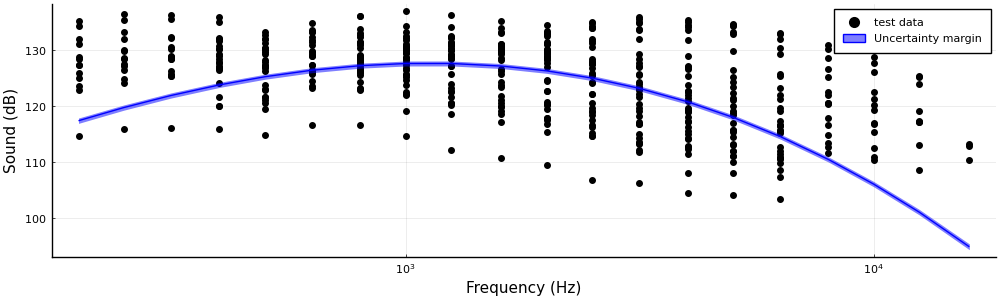

In [453]:
### YOUR CODE HERE ###
V_tst = hcat(ϕ(tst_input)...); 
sortedix_tst = sortperm(tst_input)

mean_pred = Array{Float64}(undef, length(tst_input)) 
var_pred = Array{Float64}(undef, length(tst_input)) 

# define beta
β = precision # beta = tau = precision
# β = inv(precision) # beta = tau = precision

M_n = ForneyLab.unsafeMean(posterior[:θ])
S_n = ForneyLab.unsafeCov(posterior[:θ])  


# based on formulas in regression lesson
for i = 1:M
    mean_pred[i] = dot(M_n', V_tst[i,:])
    var_pred[i] = (β)^(-1) + V_tst[i,:]' * S_n * V_tst[i,:]
end

println(sqrt.(var_pred))

# sort data for plotting
m_pred_sort = mean_pred[sortedix_tst];
std_pred_sort = sqrt.(var_pred[sortedix_tst]);
tst_input_sort = tst_data[sortedix_tst,1];
# println(mean_pred) 

# calculate standard dev ribbon
ribbon = [std_pred_sort, std_pred_sort];

scatter(tst_data[:,1], tst_output, size=(1000,300), color="black", xscale=:log10, 
        xlabel="Frequency (Hz)", ylabel="Sound (dB)", label="test data")

# plot!(unique(tst_input_sort), unique(m_pred_sort), color="blue", label="Uncertainty margin", ribbon=ribbon)

plot!(tst_input_sort, m_pred_sort, color="blue", label="Uncertainty margin", ribbon=ribbon)

## [1pt] Question 3

- Compute the maximum likelihood (ML) estimate on the training data set.
- Scatter the test data points (frequency in `xscale=:log10` on x-axis, sound on y-axis).
- Add the predictions based on the ML estimate as a solid line.
- Compute and compare the mean squared errors for both the ML and MAP estimates on the test data. 

In [441]:
### YOUR CODE HERE ###

## [3pt] Question 4

We will now treat the precision of the likelihood function as an unknown variable (i.e., we will no longer fix it using a separate estimation procedure).

- Specify a probabilistic model of order $d = 3$ where the unknown likelihood precision is given an appropriate prior distribution. 
- Define a message passing procedure to simultaneously estimate coefficients and likelihood precision.
- Infer a posterior distribution for the coefficients and the likelihood precision.

In [442]:
### YOUR CODE HERE ###

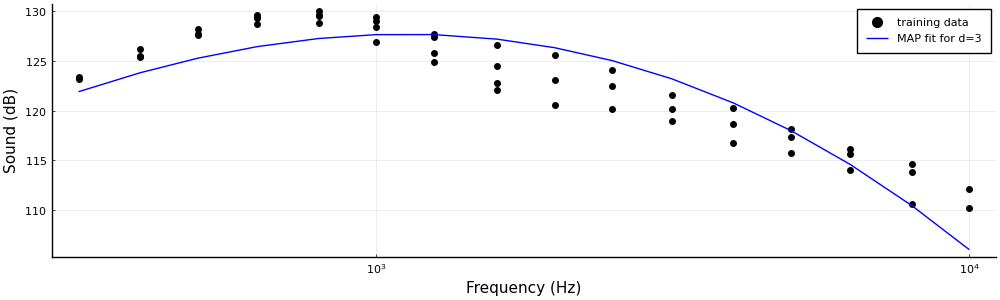

In [443]:
# Extract maximum a posteriori (MAP) estimate from posterior
θ_MAP = ForneyLab.unsafeMode(posterior[:θ]);

# Vandermonde matrix
V_trn = hcat(ϕ(trn_input)...)

# Visualize fit of current MAP estimate on training data
scatter(trn_data[:,1], trn_output, size=(1000,300), color="black", xscale=:log10, xlabel="Frequency (Hz)", ylabel="Sound (dB)", label="training data")
plot!(trn_data[sortedix_trn,1], V_trn[sortedix_trn,:]*θ_MAP, color="blue", label="MAP fit for d=3")

## [1pt] Question 5 

- Compute the posterior predictive distribution for each test data point. 

Note: that would normally require marginalizing over the precision posterior. You may use a simple approximation instead: fix the precision with the MAP estimate based on your computed posterior.
- Scatter the test data points (frequency in `xscale=:log10` on x-axis, sound on y-axis).
- Add the means of the posterior predictive distributions as a solid line.
- Add the prediction uncertainty margin of +/- $\sigma$ around the means (use the `ribbon=` keyword argument for this purpose).

Hint: if `ForneyLab.unsafeMode()` doesn't work, then you can extract the posterior parameters and compute the mode according to the expressions given in Appendix B of [Bishop's Pattern Recognition & Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).

In [444]:
### YOUR CODE HERE ###

## [2pt] Question 6

- Alter the inference procedure defined for Question 4 such that you also compute Free Energy.
- Define models for polynomials of order $d = 1, \dots, 5$ and store the Free Energy for each model.
- Select the model with the smallest free energy and report the order of the polynomial.

In [445]:
### YOUR CODE HERE ###